<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Brain_Tumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain Tumor MRI Dataset
Old Dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset <br>
New Dataset: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Dataloader

In [ ]:
import os
import sys
from torchvision import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import Counter
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


import warnings
warnings.filterwarnings("ignore")

# Set a fixed seed for reproducibility
set_seed(12)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
]))

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Calculate lengths for each split
total_size = len(dataset_)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Perform the split
train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])

# Mapping of class indices to class names
class_to_idx = dataset_.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print split information
print(f"Total samples: {len(dataset_)}")
print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Mapping of class: {idx_to_class}")

Total samples: 5712
Training samples: 4569
Validation samples: 1143
Mapping of class: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


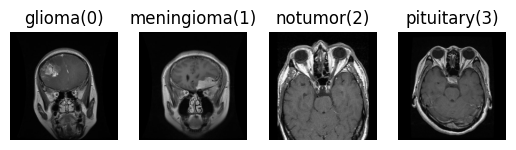

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Training/glioma/Tr-glTr_0000.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Training/meningioma/Tr-meTr_0000.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Training/notumor/Tr-noTr_0000.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Training/pituitary/Tr-piTr_0000.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

#Evaluation
The training process can be found here: https://github.com/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Training_ReseNet.ipynb<br>

Download the pretrained weights:

In [ ]:
!gdown 1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU

Downloading...
From: https://drive.google.com/uc?id=1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU
To: /content/best_model_4.pth.tar
100% 85.3M/85.3M [00:03<00:00, 26.4MB/s]


Evaluate the performance:

In [ ]:
from torchvision import models
import torch
import torch.nn as nn

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
validloader = DataLoader(val_split, batch_size=128, shuffle=False, num_workers=2)

model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))
accuracy = evaluate(model, validloader)
print('accuracy:', accuracy)

<ipython-input-6-4e1547d16f34>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_4.pth.tar'))


accuracy: 0.9641294838145232


#Active Learning in new dataset: Human in Loop Annotation

Download new dataset

In [ ]:
!gdown 1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
!unzip -q braintumor_v2.zip

Analysing new dataset:

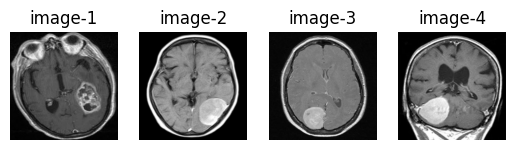

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['image-1', 'image-2', 'image-3', 'image-4']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0001.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0004.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor_v2/meningioma/Te-me_0010.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor_v2/meningioma/Te-me_0020.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

sample size of new dataset: 1311
Total dimension after t-SNE reduction: (1311, 2)


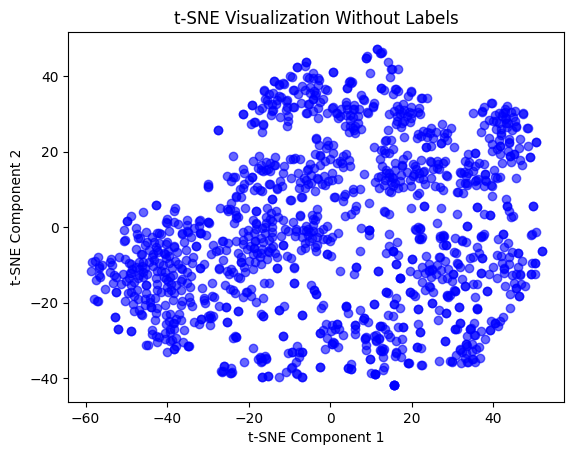

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_embedded.shape)

# Plot without labels
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6, color='blue')  # Single color

ax.set_title('t-SNE Visualization Without Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()

Plot the images into 4 clusters:

sample size of new dataset: 1311


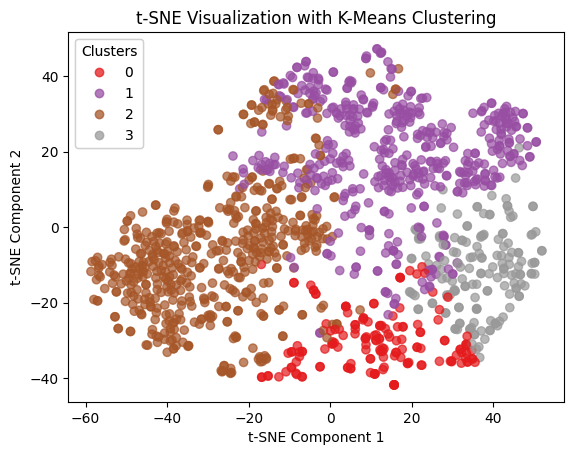

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

# Apply K-Means clustering to infer labels
num_clusters = 4  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(img_all)

# Plot with inferred cluster labels
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='Set1', alpha=0.7)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

ax.set_title('t-SNE Visualization with K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()


Uncertainty-aware sampling:

sample size of new dataset: 1311


<ipython-input-13-7ea1031a240f>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_4.pth.tar'))


Average entropy: 0.8961
Max entropy: 1.3304
Min entropy: 0.1906


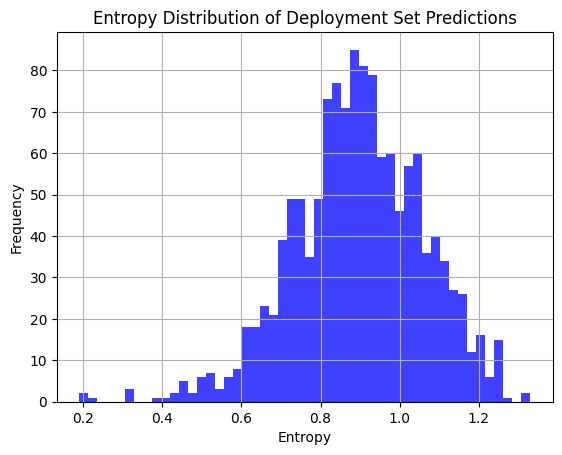

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def get_uncertainty(model, valid_loader):
    model.eval()
    entropy_list = []
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(valid_loader):  # Ignore targets if unavailable
            inputs = inputs.to(device)

            # Get model outputs (logits)
            outputs = model(inputs)

            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Compute entropy: H(p) = -sum(p * log(p))
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

            # Store entropy values
            entropy_list.extend(entropy.cpu().numpy())


    entropy_array = np.array(entropy_list)
    return entropy_array

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))
newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=True, num_workers=2)

#Prepare model
model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))

#Get Uncertainty
entropy_array = get_uncertainty(model, newdataloader)

# Print some statistics about uncertainty
print(f"Average entropy: {np.mean(entropy_array):.4f}")
print(f"Max entropy: {np.max(entropy_array):.4f}")
print(f"Min entropy: {np.min(entropy_array):.4f}")

plt.hist(entropy_array, bins=50, alpha=0.75, color='blue')
plt.title("Entropy Distribution of Deployment Set Predictions")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Sample size of new dataset: 1311
Average entropy: 0.2418
Max entropy: 1.2759
Min entropy: 0.0035
Number of high-uncertainty samples selected: 131


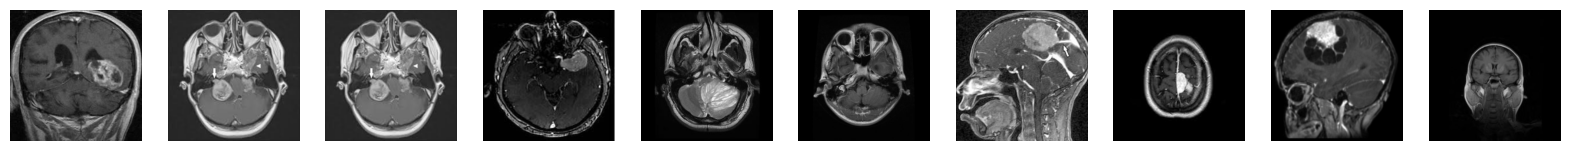

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings("ignore")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the function to get entropy-based uncertainty
def get_uncertainty(model, dataloader):
    model.eval()
    entropy_list = []
    indices_list = []  # Store indices to map back to dataset

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(dataloader):  # Ignore targets if unavailable
            inputs = inputs.to(device)

            # Get model outputs (logits)
            outputs = model(inputs)

            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Compute entropy: H(p) = -sum(p * log(p))
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

            # Store entropy values and sample indices
            start_idx = batch_idx * dataloader.batch_size
            entropy_list.extend(entropy.cpu().numpy())
            indices_list.extend(range(start_idx, start_idx + len(inputs)))

    entropy_array = np.array(entropy_list)
    return entropy_array, indices_list

# Prepare dataset
new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

print('Sample size of new dataset:', len(new_dataset))
newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=False, num_workers=2)

# Prepare model
num_classes = len(new_dataset.classes)
model = models.resnet34(weights=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar', map_location=device))

# Get uncertainty values and indices
entropy_array, sample_indices = get_uncertainty(model, newdataloader)

# Print some statistics about uncertainty
print(f"Average entropy: {np.mean(entropy_array):.4f}")
print(f"Max entropy: {np.max(entropy_array):.4f}")
print(f"Min entropy: {np.min(entropy_array):.4f}")

# Sort indices based on entropy values (descending order)
sorted_indices = np.argsort(entropy_array)[::-1]  # Sort in descending order

# Select the top 10% samples
top_10_percent = int(0.10 * len(new_dataset))
high_uncertainty_indices = [sample_indices[i] for i in sorted_indices[:top_10_percent]]

# Create a new dataset with high-uncertainty samples
high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

# Retrieve paths of the high-uncertainty samples
all_image_paths = [new_dataset.samples[i][0] for i in range(len(new_dataset))]
high_uncertainty_image_paths = [all_image_paths[idx] for idx in high_uncertainty_indices]

# Print the number of selected high-uncertainty samples
print(f"Number of high-uncertainty samples selected: {len(high_uncertainty_subset)}")

# Create DataLoader for the selected subset (optional)
high_uncertainty_loader = DataLoader(high_uncertainty_subset, batch_size=64, shuffle=False)


# Function to visualize the most uncertain samples after denormalization
def visualize_high_uncertainty_samples( indices, paths, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, img_path in enumerate(paths[:num_samples]):
        image = Image.open(img_path)
        resized_image = image.resize((224, 224))
        axes[i].imshow(resized_image)
        axes[i].axis('off')
        # axes[i].set_title(f"\n{paths[i].split('/')[-2:]}", fontsize=8)

    plt.show()

# Visualize top 10 highest uncertainty samples with their file paths
visualize_high_uncertainty_samples( high_uncertainty_indices, high_uncertainty_image_paths)



#Retrain the model with new annotated dataset

In [ ]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed for reproducibility
set_seed(42)
#Set GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=5, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

def get_high_uncertained_indices(new_dataset):
    newdataloader = DataLoader(new_dataset, batch_size=128, shuffle=False, num_workers=2)
    model_ = models.resnet34(weights=True)
    model_.fc = nn.Linear(model_.fc.in_features, 4)
    model_.load_state_dict(torch.load('best_model_4.pth.tar', map_location=device))
    model_.to(device)

    model_.eval()
    entropy_list = []
    indices_list = []  # Store indices to map back to dataset

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(newdataloader):  # Ignore targets if unavailable
            inputs = inputs.to(device)

            # Get model outputs (logits)
            outputs = model_(inputs)

            # Convert logits to probabilities
            probabilities = F.softmax(outputs, dim=1)

            # Compute entropy: H(p) = -sum(p * log(p))
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

            # Store entropy values and sample indices
            start_idx = batch_idx * newdataloader.batch_size
            entropy_list.extend(entropy.cpu().numpy())
            indices_list.extend(range(start_idx, start_idx + len(inputs)))

    entropy_array = np.array(entropy_list)

    # Print some statistics about uncertainty
    print(f"Average entropy: {np.mean(entropy_array):.4f}")
    print(f"Max entropy: {np.max(entropy_array):.4f}")
    print(f"Min entropy: {np.min(entropy_array):.4f}")

    # Sort indices based on entropy values (descending order)
    sorted_indices = np.argsort(entropy_array)[::-1]  # Sort in descending order

    # Select the top 10% samples
    top_10_percent = int(0.10 * len(new_dataset))
    high_uncertainty_indices = [sample_indices[i] for i in sorted_indices[:top_10_percent]]
    return high_uncertainty_indices


if __name__ == '__main__':
    args = get_arguments()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    # Prepare original dataset
    dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    # Define split ratios
    train_ratio = 0.8
    val_ratio = 0.2

    # Calculate lengths for each split
    total_size = len(dataset_)
    train_size = int(total_size * train_ratio)
    val_size = total_size - train_size

    # Perform the split
    train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])
    print('Training on:', device, 'train sample size:', len(train_split), 'valid sample size:', len(val_split))

    # Prepare new dataset
    new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

    # Get high uncertainity indices
    high_uncertainty_indices = get_high_uncertained_indices(new_dataset)

    # Create a new dataset with high-uncertainty samples
    high_uncertainty_subset = Subset(new_dataset, high_uncertainty_indices)

    # Merge the subsets
    merged_dataset = ConcatDataset([high_uncertainty_subset, train_split])
    print('Training on:', device, 'merged train sample size:', len(merged_dataset), 'valid sample size:', len(val_split))

    # Prepare dataloader
    trainloader = DataLoader(merged_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(val_split, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    print(dataset_.class_to_idx)

    model = models.resnet34(weights=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth.tar')
        print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 4569 valid sample size: 1143
Average entropy: 0.2418
Max entropy: 1.2759
Min entropy: 0.0035
Training on: cuda merged train sample size: 4700 valid sample size: 1143
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
epoch: 0  acc: 0.9816  best epoch: 0  best acc: 0.9816
epoch: 1  acc: 0.9860  best epoch: 1  best acc: 0.9860
epoch: 2  acc: 0.9843  best epoch: 1  best acc: 0.9860
epoch: 3  acc: 0.9886  best epoch: 3  best acc: 0.9886
epoch: 4  acc: 0.9843  best epoch: 3  best acc: 0.9886
